In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
gtzan = '/content/drive/MyDrive/MiniProject/GTZANUpdated'
genre_folders=os.listdir(gtzan)
print(genre_folders)
# make dict of key folder name and value list of files contained in it
genre_files={}
for genre in genre_folders:
  genre_files[genre]=os.listdir(os.path.join(gtzan,genre))
print(genre_files)

['blues', 'classical', 'pop', 'disco', 'metal', 'hiphop', 'reggae', 'jazz', 'rock', 'country']
{'blues': ['blues.00000.wav', 'blues.00011.wav', 'blues.00007.wav', 'blues.00003.wav', 'blues.00010.wav', 'blues.00005.wav', 'blues.00002.wav', 'blues.00004.wav', 'blues.00006.wav', 'blues.00012.wav', 'blues.00008.wav', 'blues.00009.wav', 'blues.00013.wav', 'blues.00001.wav', 'blues.00021.wav', 'blues.00023.wav', 'blues.00016.wav', 'blues.00024.wav', 'blues.00025.wav', 'blues.00015.wav', 'blues.00018.wav', 'blues.00022.wav', 'blues.00019.wav', 'blues.00020.wav', 'blues.00017.wav', 'blues.00014.wav', 'blues.00029.wav', 'blues.00038.wav', 'blues.00028.wav', 'blues.00037.wav', 'blues.00031.wav', 'blues.00032.wav', 'blues.00034.wav', 'blues.00030.wav', 'blues.00036.wav', 'blues.00035.wav', 'blues.00027.wav', 'blues.00039.wav', 'blues.00033.wav', 'blues.00026.wav', 'blues.00051.wav', 'blues.00046.wav', 'blues.00052.wav', 'blues.00044.wav', 'blues.00050.wav', 'blues.00047.wav', 'blues.00053.wav', '

MFCC Feature extraction


In [4]:
import librosa
def extract_mfcc(file_path, max_len = 200):
    y, sr = librosa.load(file_path, sr=None)
    mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40)
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

  # y,sr=librosa.load(file_path)
  # mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40)
  # return mfcc

In [5]:
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [6]:
from tqdm import tqdm
mfcc_X = []
mfcc_y = []

for genre, files in genre_files.items():
    for file in tqdm(files, desc=f"Processing {genre}"):
        mfcc = extract_mfcc(os.path.join(gtzan, genre, file))
        if mfcc is not None:
          mfcc_X.append(mfcc)
          mfcc_y.append(genre_folders.index(genre))



Processing country: 100%|██████████| 120/120 [01:17<00:00,  1.55it/s]


In [7]:
max_length = max([mfcc.shape[1] for mfcc in mfcc_X])

# Pad the sequences to have the same length
mfcc_X = np.array([np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant') for mfcc in mfcc_X])

# Convert y to a NumPy array
mfcc_y = np.array(mfcc_y)

# Add a channel dimension to X
mfcc_X = mfcc_X[..., np.newaxis]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.01, random_state=42)
# gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu = gpus[0]
# tf.config.experimental.set_memory_growth(gpu, True)

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# # Optimize the dataset
# batch_size = 32
# train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, max_length, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(genre_folders), activation='softmax')
])

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
35/35 [==============================] - 14s 354ms/step - loss: 3.3440 - accuracy: 0.1887 - val_loss: 1.6689 - val_accuracy: 0.3333
Epoch 2/15
35/35 [==============================] - 11s 302ms/step - loss: 1.7728 - accuracy: 0.3506 - val_loss: 1.3178 - val_accuracy: 0.3333
Epoch 3/15
35/35 [==============================] - 13s 360ms/step - loss: 1.4981 - accuracy: 0.4365 - val_loss: 1.2692 - val_accuracy: 0.5833
Epoch 4/15
35/35 [==============================] - 13s 359ms/step - loss: 1.2722 - accuracy: 0.5376 - val_loss: 1.1494 - val_accuracy: 0.5833
Epoch 5/15
35/35 [==============================] - 13s 366ms/step - loss: 1.0570 - accuracy: 0.6270 - val_loss: 1.3137 - val_accuracy: 0.5000
Epoch 6/15
35/35 [==============================] - 12s 356ms/step - loss: 0.7848 - accuracy: 0.7567 - val_loss: 1.1591 - val_accuracy: 0.4167
Epoch 7/15
35/35 [==============================] - 11s 301ms/step - loss: 0.5990 - accuracy: 0.8041 - val_loss: 1.1756 - val_accuracy: 0.6667

In [10]:
model.save('/content/drive/MyDrive/MiniProject/Models/cnn-mpcc-100-15-updated.keras')
model.save('/content/drive/MyDrive/MiniProject/Models/cnn-mpcc-100-15-updated.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
loss, overall_accuracy = model.evaluate(X_test, y_test)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")

1/1 [==============================] - 0s 81ms/step - loss: 2.2104 - accuracy: 0.5000
Overall Test Accuracy: 50.00%


In [12]:
genre_accuracies = []
genre_names = []

genre_to_label = {genre: i for i, genre in enumerate(genre_folders)}
# X_train, X_test, y_train, y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.3, random_state=50)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

for genre in genre_folders:
    genre_index = genre_to_label[genre]
    genre_indices = np.where(y_true == genre_index)[0]
    if len(genre_indices) > 0:
        genre_accuracy = np.mean(y_pred_classes[genre_indices] == y_true[genre_indices])
        genre_accuracies.append(genre_accuracy)
        genre_names.append(genre.capitalize())
        print(f"Accuracy for {genre.capitalize()}: {genre_accuracy * 100:.2f}%")


1/1 [==============================] - 0s 223ms/step
Accuracy for Classical: 100.00%
Accuracy for Pop: 100.00%
Accuracy for Metal: 50.00%
Accuracy for Reggae: 50.00%
Accuracy for Jazz: 50.00%
Accuracy for Rock: 50.00%
Accuracy for Country: 0.00%


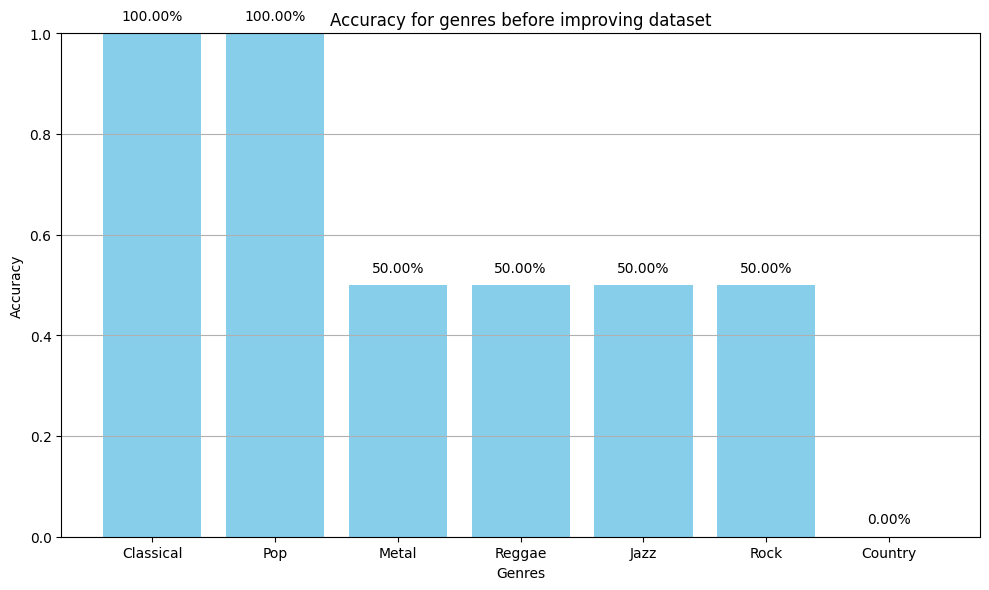

In [13]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(genre_names, genre_accuracies, color='skyblue')
plt.title('Accuracy for genres before improving dataset')
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set ylim to 0-100%
plt.grid(axis='y')
for i, v in enumerate(genre_accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [14]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, max_length, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(genre_folders), activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
35/35 [==============================] - 13s 323ms/step - loss: 3.6350 - accuracy: 0.2084 - val_loss: 1.6059 - val_accuracy: 0.5833
Epoch 2/20
35/35 [==============================] - 13s 363ms/step - loss: 1.7176 - accuracy: 0.3819 - val_loss: 1.5754 - val_accuracy: 0.4167
Epoch 3/20
35/35 [==============================] - 12s 352ms/step - loss: 1.4355 - accuracy: 0.4875 - val_loss: 1.5898 - val_accuracy: 0.5000
Epoch 4/20
35/35 [==============================] - 13s 359ms/step - loss: 1.3143 - accuracy: 0.5277 - val_loss: 1.2316 - val_accuracy: 0.5833
Epoch 5/20
35/35 [==============================] - 12s 338ms/step - loss: 1.0561 - accuracy: 0.6181 - val_loss: 1.0316 - val_accuracy: 0.5000
Epoch 6/20
35/35 [==============================] - 12s 335ms/step - loss: 0.8742 - accuracy: 0.6923 - val_loss: 0.7378 - val_accuracy: 0.6667
Epoch 7/20
35/35 [==============================] - 14s 408ms/step - loss: 0.7377 - accuracy: 0.7451 - val_loss: 1.8499 - val_accuracy: 0.5833

In [15]:
model.save('/content/drive/MyDrive/MiniProject/Models/cnn-mpcc-100-20-updated.keras')
model.save('/content/drive/MyDrive/MiniProject/Models/cnn-mpcc-100-20-updated.h5')

In [16]:
loss, overall_accuracy = model2.evaluate(X_test, y_test)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")
genre_accuracies = []
genre_names = []

genre_to_label = {genre: i for i, genre in enumerate(genre_folders)}
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

for genre in genre_folders:
    genre_index = genre_to_label[genre]
    genre_indices = np.where(y_true == genre_index)[0]
    if len(genre_indices) > 0:
        genre_accuracy = np.mean(y_pred_classes[genre_indices] == y_true[genre_indices])
        genre_accuracies.append(genre_accuracy)
        genre_names.append(genre.capitalize())
        print(f"Accuracy for {genre.capitalize()}: {genre_accuracy * 100:.2f}%")

1/1 [==============================] - 0s 65ms/step - loss: 2.4684 - accuracy: 0.6667
Overall Test Accuracy: 66.67%
1/1 [==============================] - 0s 113ms/step
Accuracy for Classical: 100.00%
Accuracy for Pop: 100.00%
Accuracy for Metal: 50.00%
Accuracy for Reggae: 50.00%
Accuracy for Jazz: 100.00%
Accuracy for Rock: 100.00%
Accuracy for Country: 0.00%


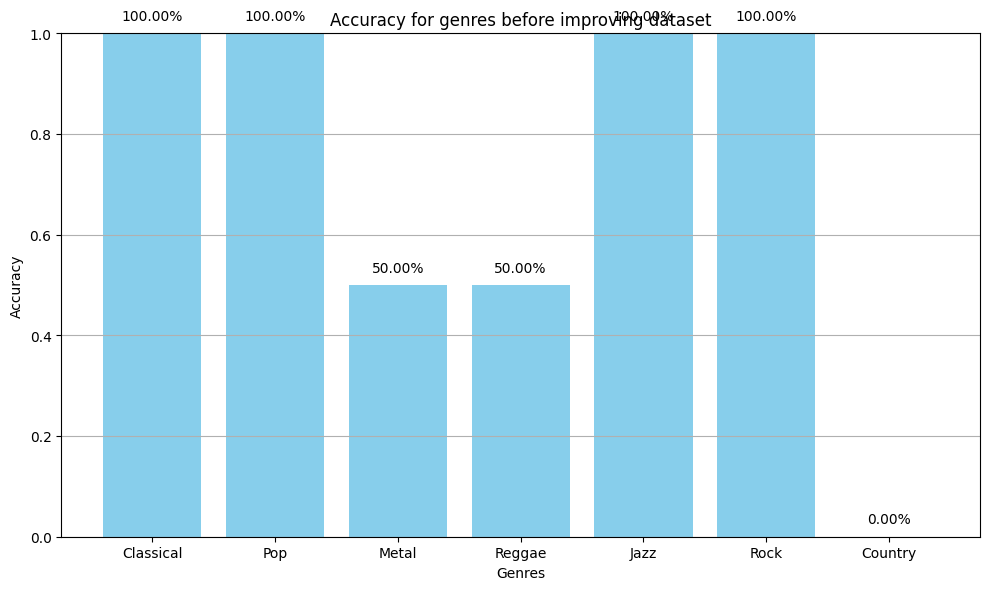

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(genre_names, genre_accuracies, color='skyblue')
plt.title('Accuracy for genres before improving dataset')
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set ylim to 0-100%
plt.grid(axis='y')
for i, v in enumerate(genre_accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [18]:
import pickle
with open('/content/drive/MyDrive/MiniProject/Models/mfcc-featuresX.pkl', 'wb') as f:
    pickle.dump(mfcc_X, f)
with open('/content/drive/MyDrive/MiniProject/Models/mfcc-featuresY.pkl', 'wb') as f:
    pickle.dump(mfcc_y, f)
